In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import nibabel as nib

PATH = "/home/mariopasc/Python/Datasets/Meningiomas/meningioma"
PATIENT = "P1"
PULSES = ["T1", "T2", "SUSC"]
OUTPUT_PATH = "/home/mariopasc/Python/Datasets/Meningiomas/meningioma"

In [3]:
suf = "_registered_sri24"

data = {}
for pulse in PULSES:
    file = os.path.join(PATH, PATIENT, f"{pulse}_1"+suf+".nii.gz")
    seg = os.path.join(PATH, PATIENT, f"{pulse}_1_mask"+suf+".nii.gz")
    img = nib.load(file)
    seg = nib.load(seg)

    data[pulse] = {
        "vol": img.get_fdata(),
        "seg": seg.get_fdata(),
    }

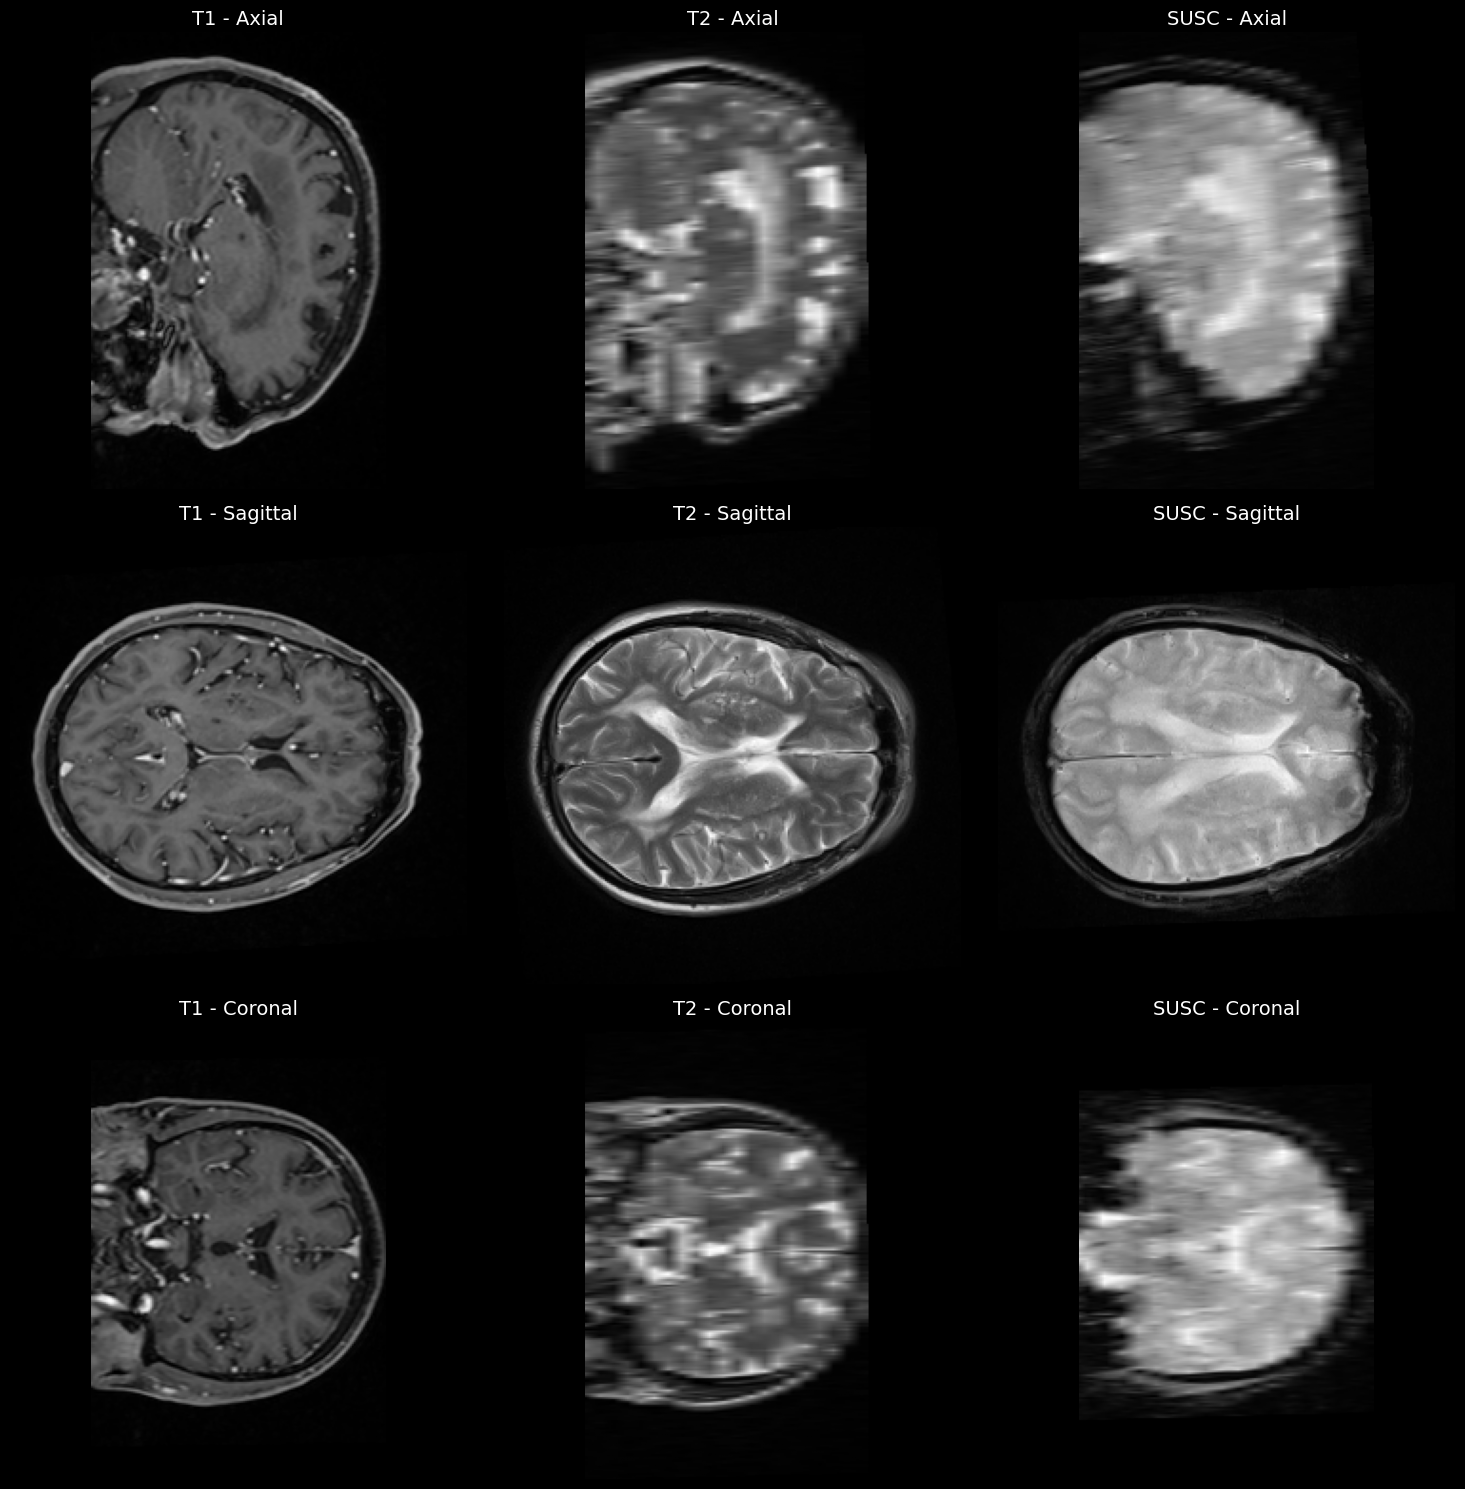

In [ ]:
# Visualize original data in a 3x3 grid (pulses × views)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig.patch.set_facecolor('black')

# Get middle slices for each view
for col, pulse in enumerate(PULSES):
    vol = data[pulse]["vol"]
    seg = data[pulse]["seg"]
    
    # Get middle slice indices
    axial_slice = vol.shape[0] // 2
    coronal_slice = vol.shape[1] // 2
    sagittal_slice = vol.shape[2] // 2
    
    # Axial view (top row)
    axes[0, col].imshow(vol[axial_slice], cmap='gray')
    axes[0, col].imshow(np.ma.where(seg[axial_slice] == 1, 1, np.nan), cmap='Reds_r', alpha=0.5)
    axes[0, col].set_title(f"{pulse} - Axial", color='white', fontsize=14)
    axes[0, col].axis('off')
    
    # Sagittal view (middle row)
    axes[1, col].imshow(vol[:, :, sagittal_slice], cmap='gray')
    axes[1, col].imshow(np.ma.where(seg[:, :, sagittal_slice] == 1, 1, np.nan), cmap='Reds_r', alpha=0.5)
    axes[1, col].set_title(f"{pulse} - Sagittal", color='white', fontsize=14)
    axes[1, col].axis('off')
    
    # Coronal view (bottom row)
    axes[2, col].imshow(vol[:, coronal_slice], cmap='gray')
    axes[2, col].imshow(np.ma.where(seg[:, coronal_slice] == 1, 1, np.nan), cmap='Reds_r', alpha=0.5)
    axes[2, col].set_title(f"{pulse} - Coronal", color='white', fontsize=14)
    axes[2, col].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"original_visualization_P{PATIENT}.png"), 
            facecolor='black', bbox_inches='tight', dpi=150)
plt.show()

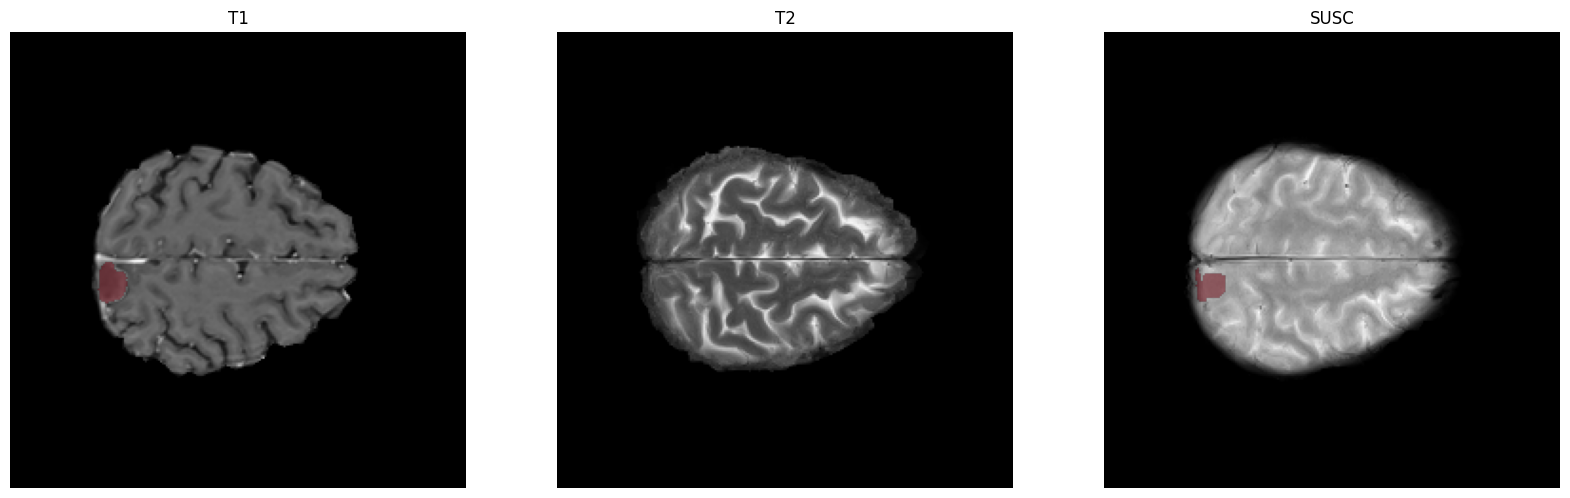

(240, 240, 155)
(240, 240, 155)
(240, 240, 155)


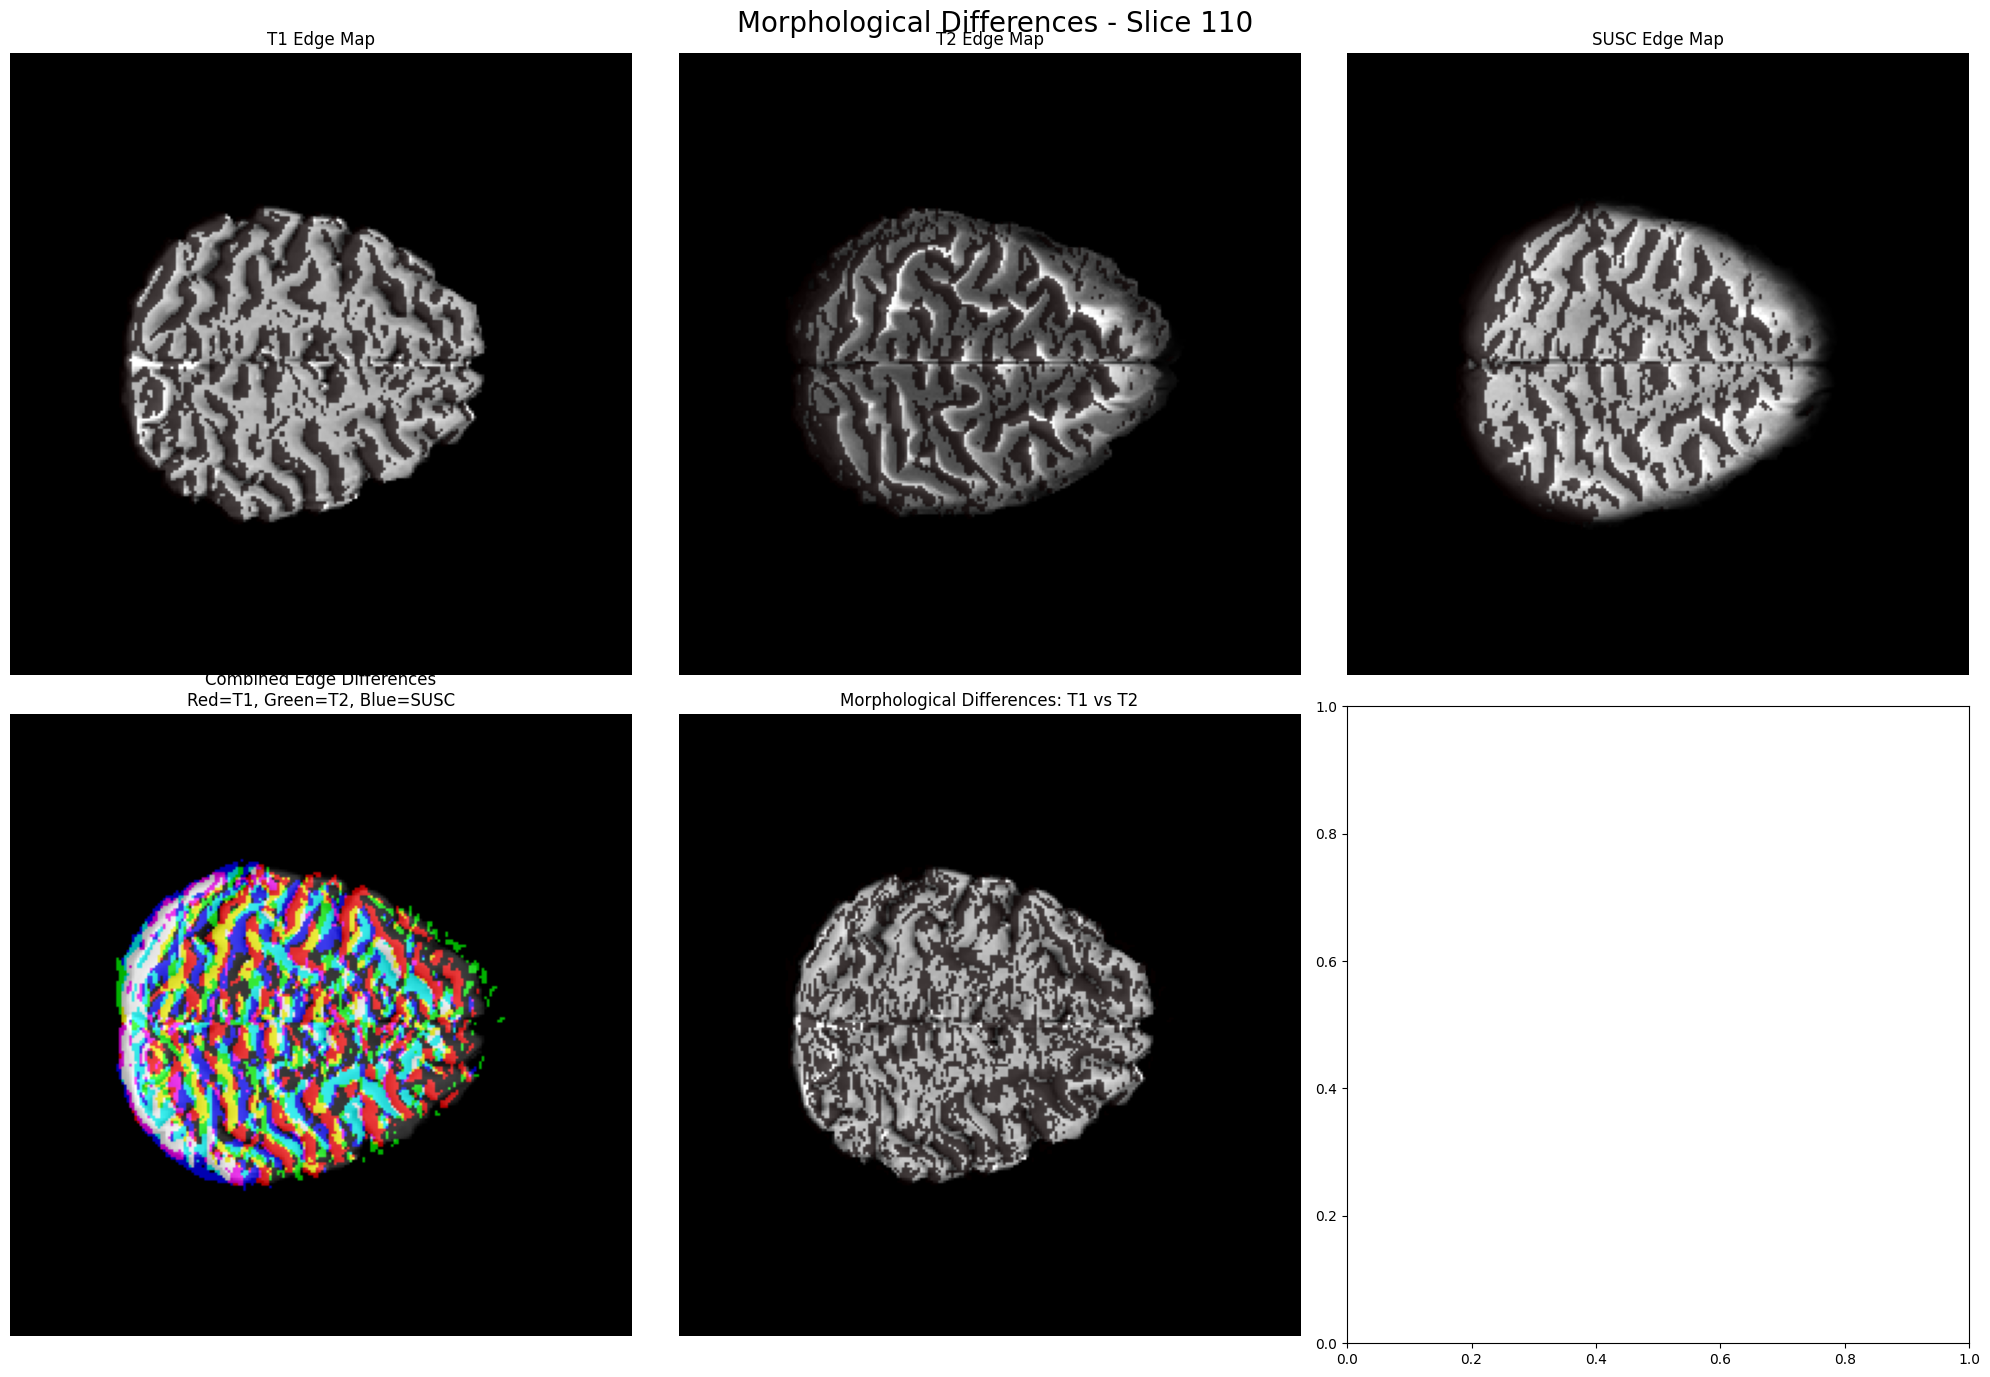


Morphological Differences (Edge Similarity):
T1 vs T2: 0.7228
T1 vs SUSC: 0.7981
T2 vs SUSC: 0.6328


In [ ]:
# New visualization for morphological differences
# 1. First normalize the images to have comparable intensity ranges
normalized_data = {}
for pulse in PULSES:
    vol = data[pulse]["vol"][:, :, slice].copy()
    # Ignore zeros in normalization calculation
    mask = vol > 0
    if mask.any():
        p1, p99 = np.percentile(vol[mask], (1, 99))
        vol = np.clip(vol, p1, p99)
        vol = (vol - p1) / (p99 - p1)
    normalized_data[pulse] = vol

# 2. Create edge maps to highlight structural boundaries
from scipy import ndimage
edge_maps = {}
for pulse in PULSES:
    # Apply Sobel edge detection
    edges = ndimage.sobel(normalized_data[pulse])
    # Threshold to binary edge map
    edge_thresh = np.percentile(edges, 90)  # Adjust threshold as needed
    edge_maps[pulse] = edges > edge_thresh

# 3. Visualize morphological differences
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle(f"Morphological Differences - Slice {slice}", fontsize=20)

# First row: Show the edge maps for each pulse
for i, pulse in enumerate(PULSES):
    if i < 3:  # Only handles up to 3 pulses
        ax = axes[0, i]
        # Display original image
        ax.imshow(normalized_data[pulse], cmap="gray")
        # Overlay edges
        ax.imshow(np.ma.masked_where(~edge_maps[pulse], edge_maps[pulse]), 
                 cmap="hot", alpha=0.7)
        ax.set_title(f"{pulse} Edge Map")
        ax.axis("off")

# Second row: Difference maps between pulses
# Create a combined visualization where different colors show where edges differ
combined_edges = np.zeros((*edge_maps[PULSES[0]].shape, 3))

# Color code: R=T1, G=T2, B=SUSC
# Areas where all match will be white, where some match will be color combinations
combined_edges[:, :, 0] = edge_maps["T1"]   # Red channel: T1 edges
combined_edges[:, :, 1] = edge_maps["T2"]   # Green channel: T2 edges
combined_edges[:, :, 2] = edge_maps["SUSC"] # Blue channel: SUSC edges

# Show the overlay of all edge maps
axes[1, 0].imshow(normalized_data["T1"], cmap="gray")
axes[1, 0].imshow(combined_edges, alpha=0.7)
axes[1, 0].set_title("Combined Edge Differences\nRed=T1, Green=T2, Blue=SUSC")
axes[1, 0].axis("off")

# Create a specific difference map (T1 vs T2)
diff_mask_t1_t2 = edge_maps["T1"] != edge_maps["T2"]
axes[1, 1].imshow(normalized_data["T1"], cmap="gray")
axes[1, 1].imshow(np.ma.masked_where(~diff_mask_t1_t2, diff_mask_t1_t2), 
                 cmap="hot", alpha=0.7)
axes[1, 1].set_title("Morphological Differences: T1 vs T2")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

# Add a quantitative measure of morphological difference
def morphological_difference(img1, img2):
    """Calculate a simple morphological difference metric between two images."""
    # Calculate edges for both images
    edges1 = ndimage.sobel(img1) > np.percentile(ndimage.sobel(img1), 90)
    edges2 = ndimage.sobel(img2) > np.percentile(ndimage.sobel(img2), 90)
    
    # Calculate difference
    diff = np.logical_xor(edges1, edges2)
    
    # Percentage of different edge pixels
    return np.sum(diff) / (np.sum(edges1) + np.sum(edges2) - np.sum(np.logical_and(edges1, edges2)))

# Calculate pairwise differences
print("\nMorphological Differences (Edge Similarity):")
for i, pulse1 in enumerate(PULSES):
    for j, pulse2 in enumerate(PULSES):
        if i < j:  # Only calculate for unique pairs
            diff = morphological_difference(normalized_data[pulse1], normalized_data[pulse2])
            print(f"{pulse1} vs {pulse2}: {diff:.4f}")

In [ ]:
slice = 100
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i, pulse in enumerate(PULSES):
    if pulse == "T1":
        slice = 100
    elif pulse == "T2":
        slice = 95
    elif pulse == "SUSC":
        slice = 105
    ax[i].imshow(data[pulse]["vol"][:, :, slice], cmap="gray")
    ax[i].imshow(np.ma.where(data[pulse]["seg"][:, :, slice] == 1, 1, np.nan), cmap="Reds_r", alpha=0.5)
    ax[i].set_title(pulse)
    ax[i].axis("off")

plt.show()
